# Code

In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import pickle
import math
import torch
from tqdm.notebook import tqdm
import seaborn as sns
from torch.utils.data import DataLoader
# if its_jupyter_notebook:
#     sys.argv = [''] #Remove this if it's not a jupyter notebook!

import sys
sys.path.insert(0, '..')

%load_ext autoreload
%autoreload 2
from dataset.data import (
    RNADataset,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    plot_sample,
    #plot_sample2,
    seed_everything,
)
from config import *

In [3]:
df_genes = pd.read_csv(os.path.join(processed_files_dir, "df_genes.csv"))
df = pd.read_csv(os.path.join(processed_files_dir, "final_df.csv"))

In [4]:
#the N in the cdna creates problem with the tokenizer
df_genes['problematic_set'] = df_genes['cdna'].apply(lambda x: False if (set(x) - set({'A', 'C', 'G', 'T'}) == set()) else True)
genesN = set(df_genes[df_genes.problematic_set].gene_id.values)
print(f'{len(genesN)} genes have N, so will be excluded')
df = df[~(df.gene1.isin(genesN))|(df.gene2.isin(genesN))].reset_index(drop = True)

2 genes have N, so will be excluded


In [5]:
with open(os.path.join(rna_rna_files_dir, f"gene_pairs_training.txt"), "rb") as fp:  # Unpickling
    subset_train = pickle.load(fp)
    subset_train = pd.Series(subset_train).str.split('_', expand = True)
    genes_train = set(subset_train[0]).union(set(subset_train[1]))

In [6]:
limit_small_rna = 7000
limit_medium_rna = 8500

print('MAX_RNA_SIZE is', MAX_RNA_SIZE)
print('limit of small rna is:', limit_small_rna)
print('limit of medium rna is:', limit_medium_rna)

small1 = df[(df.length_2<=limit_small_rna)&(df.length_1<=limit_medium_rna)] #both smal and one small the other medium
small2 = df[(df.length_1<=limit_small_rna)&(df.length_2<=limit_medium_rna)] #both smal and one small the other medium
df_small = pd.concat([small1, small2], axis = 0).drop_duplicates().reset_index(drop = True) #one small the other medium

df_big = df[(df.length_1>limit_medium_rna)&(df.length_2>limit_medium_rna)].reset_index(drop=True)

df_medium = df[~df.couples.isin(set(df_small.couples).union(set(df_big.couples)))].reset_index(drop=True)
assert (df_small.shape[0]+df_medium.shape[0]+df_big.shape[0]) == df.shape[0]
set(df_small.couples).union(set(df_medium.couples)).union(set(df_big.couples)) == set(df.couples)
perc_small = np.round(df_small.shape[0]/df.shape[0]*100, 1)
perc_medium = np.round(df_medium.shape[0]/df.shape[0]*100, 1)
perc_big = np.round(df_big.shape[0]/df.shape[0]*100, 1)
print(f'The amount of contact matrixes (in the entire dataset) that are small is {perc_small}% ')
print(f'The amount of contact matrixes (in the entire dataset) that are medium is {perc_medium}% ')
print(f'The amount of contact matrixes (in the entire dataset) that are big is {perc_big}% ')

MAX_RNA_SIZE is 5970
limit of small rna is: 7000
limit of medium rna is: 8500
The amount of contact matrixes (in the entire dataset) that are small is 76.1% 
The amount of contact matrixes (in the entire dataset) that are medium is 22.1% 
The amount of contact matrixes (in the entire dataset) that are big is 1.8% 


In [7]:
def create_sample_dict(id_couple, sample):
    """
    x1, x2, y1, y2 is where is the interaction with respect to the actual coordinates (not the original coordinates)
    length_1, length_2 is the length with respect to the actual length (not the original length)
    
    original_x1, original_x2, original_y1, original_y2 is where the rna interacts with respect to original coordinates 
    window_x1, window_x2, window_y1, window_y2 is where the rna was sampled with respect to original coordinates 
    original_length1, original_length2 is the original length
    """
    d = {
        'id_sample':id_couple,
        'couples':sample.couple_id,
        'gene1':sample.gene1,
        'gene2':sample.gene2,
        'interacting':sample.interacting,
        'length_1':sample.bbox.x2-sample.bbox.x1,
        'length_2':sample.bbox.y2-sample.bbox.y1,
        'protein_coding_1':sample.gene1_info["protein_coding"],
        'protein_coding_2':sample.gene2_info["protein_coding"],
        'x1': sample.seed_interaction_bbox.x1- sample.bbox.x1,
        'x2': sample.seed_interaction_bbox.x2 - sample.bbox.x1,
        'y1': sample.seed_interaction_bbox.y1 - sample.bbox.y1,
        'y2': sample.seed_interaction_bbox.y2 - sample.bbox.y1,
        'policy':sample.policy,
        'cdna1':sample.gene1_info["cdna"][sample.bbox.x1:sample.bbox.x2],
        'cdna2':sample.gene2_info["cdna"][sample.bbox.y1:sample.bbox.y2],
        'original_x1':sample.seed_interaction_bbox.x1,
        'original_x2':sample.seed_interaction_bbox.x2,
        'original_y1':sample.seed_interaction_bbox.y1,
        'original_y2':sample.seed_interaction_bbox.y2,
        'window_x1':sample.bbox.x1,
        'window_x2':sample.bbox.x2,
        'window_y1':sample.bbox.y1,
        'window_y2':sample.bbox.y2,
        'original_length1':len(sample.gene1_info["cdna"]),
        'original_length2':len(sample.gene2_info["cdna"]),
        'id_gene1_sample':sample.gene1 + '_' + str(sample.bbox.x1) + '_' + str(sample.bbox.x2),
        'id_gene2_sample':sample.gene2 + '_' + str(sample.bbox.y1) + '_' + str(sample.bbox.y2)
    }
    return d

def get_dataset(ep_per_sample, sn_per_sample, en_persample, hn_per_sample, df_genes, df, subset_file, pos_width_multipliers, pos_height_multipliers, neg_width_windows, neg_height_windows):
    assert np.round(sum(pos_width_multipliers.values()), 4) == np.round(sum(neg_width_windows.values()), 4) == 1
    
    pol = []
    
    if ep_per_sample>0:
        pol.append(
            EasyPosAugment(
            per_sample=ep_per_sample,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=pos_width_multipliers,
            height_multipliers=pos_height_multipliers,
            )
        )
        
    if sn_per_sample>0:
        pol.append(   
            SmartNegAugment(
                per_sample=sn_per_sample,
                interaction_selection=InteractionSelectionPolicy.LARGEST,
                width_multipliers=pos_width_multipliers,
                height_multipliers=pos_height_multipliers,
            )
        )
        
    if en_persample>0:
        pol.append( 
            EasyNegAugment(
                per_sample=en_persample,
                width_windows=neg_width_windows,
                height_windows=neg_height_windows,
            )
        )
        
    if hn_per_sample>0:
        pol.append(
            HardNegAugment(
                per_sample=hn_per_sample,
                width_windows=neg_width_windows,
                height_windows=neg_height_windows,
            )
        )
        
    dataset = RNADataset(
            gene2info=df_genes,
            interactions=df,
            subset_file=subset_file,
            augment_policies=pol,
    )
    return dataset 

def create_gene_count(df, unbalanced_ratio):
    gene_count = pd.concat([df[['gene1', 'interacting']].rename({'gene1':'gene'}, axis = 1),
                            df[['gene2','interacting']].rename({'gene2':'gene'}, axis = 1)], axis = 0).reset_index(drop = True)
    g = gene_count.groupby('gene').sum()
    g['not_interacting'] = gene_count.groupby('gene').count() - gene_count.groupby('gene').sum()
    g['not_interacting'] = g['not_interacting']*unbalanced_ratio
    g = g.reset_index() #add the gene column from the index
    g['diff'] = g['not_interacting'] - g['interacting']
    g['abs_diff'] = g['diff'].abs()
    g['tot'] = g['interacting'] + g['not_interacting']
    g['abs_diff_weighted'] = g['tot']*g['abs_diff']
    return g

In [8]:
pos_width_multipliers = {1_000_000: 1.}
pos_height_multipliers = pos_width_multipliers
neg_width_windows = {(MAX_RNA_SIZE-1, MAX_RNA_SIZE): float(1),}
neg_height_windows = neg_width_windows

In [9]:
#small policies
ep_per_sample_small=1
sn_per_sample_small=1
en_per_sample_small=0.1
hn_per_sample_small=0

#medium policies
ep_per_sample_medium=2
sn_per_sample_medium=2
en_per_sample_medium=0.2
hn_per_sample_medium=0.3


#big policies
ep_per_sample_big=4
sn_per_sample_big=4
en_per_sample_big=0.5
hn_per_sample_big=1

In [10]:
tot_ep = ep_per_sample_small*perc_small + ep_per_sample_medium*perc_medium + ep_per_sample_big*perc_big
tot_sn = sn_per_sample_small*perc_small + sn_per_sample_medium*perc_medium + sn_per_sample_big*perc_big
tot_en = en_per_sample_small*perc_small + en_per_sample_medium*perc_medium + en_per_sample_big*perc_big
tot_hn = hn_per_sample_small*perc_small + hn_per_sample_medium*perc_medium + hn_per_sample_big*perc_big

tot_neg = tot_sn + tot_en + tot_hn
print(f'expected smartneg are the {np.round( tot_sn/tot_neg *100, 2)}% of negative pairs')
print(f'expected easyneg are the {np.round( tot_en/tot_neg *100, 2)}% of negative pairs')
print(f'expected hardneg are the {np.round( tot_hn/tot_neg *100, 2)}% of negative pairs')

unbalanced_factor = df[df.interacting == False].shape[0]/df.shape[0]
expected_uf = (tot_ep*unbalanced_factor) / ((tot_ep*unbalanced_factor) + tot_neg)
print(f'expected unbalanced factor is {np.round(expected_uf*100, 2)}%')

expected smartneg are the 85.65% of negative pairs
expected easyneg are the 8.69% of negative pairs
expected hardneg are the 5.66% of negative pairs
expected unbalanced factor is 36.19%


# Data loader train

In [11]:
set_data = 'training' 
assert set_data in ['training', 'val', 'test']
subset_file = os.path.join(rna_rna_files_dir, f"gene_pairs_{set_data}.txt")

id_couple = 0
meta = {}

In [12]:
start_time = time.time()

small = get_dataset(ep_per_sample=ep_per_sample_small, sn_per_sample=sn_per_sample_small, 
                    en_persample=en_per_sample_small, hn_per_sample=hn_per_sample_small, 
                    df_genes=df_genes, df=df_small, subset_file=subset_file, 
                    pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                    neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(small), total = len(small)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
medium = get_dataset(ep_per_sample=ep_per_sample_medium, sn_per_sample=sn_per_sample_medium,
                     en_persample=en_per_sample_medium, hn_per_sample=hn_per_sample_medium, 
                     df_genes=df_genes, df=df_medium, subset_file=subset_file,
                     pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                     neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(medium), total = len(medium)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
big = get_dataset(ep_per_sample=ep_per_sample_big, sn_per_sample=sn_per_sample_big, 
                  en_persample=en_per_sample_big, hn_per_sample=hn_per_sample_big, 
                  df_genes=df_genes, df=df_big, subset_file=subset_file, 
                  pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                  neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(big), total = len(big)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
df_meta = pd.DataFrame.from_dict(meta, 'index')
df_meta['lencdna1'] = df_meta.apply(lambda x: len(x.cdna1), axis = 1)
df_meta['lencdna2'] = df_meta.apply(lambda x: len(x.cdna2), axis = 1)
assert (df_meta['lencdna1'] == df_meta['length_1']).all()
assert (df_meta['lencdna2'] == df_meta['length_2']).all()
assert ((df_meta.window_x2 - df_meta.window_x1)==(df_meta.lencdna1)).all()
assert ((df_meta.window_y2 - df_meta.window_y1)==(df_meta.lencdna2)).all()
df_meta = df_meta.drop(['lencdna1', 'lencdna2'], axis = 1)

m = df_meta[df_meta.policy.isin({'smartneg', 'easypos'})]
assert (m.x1 >= 0).all()
assert (m.y1 >= 0).all()
assert (m.x2 <= m.length_1).all()
assert (m.y2 <= m.length_2).all()

assert df_meta[df_meta.length_1==df_meta.original_length1][['gene1', 'id_gene1_sample']].groupby('gene1').nunique().max().iloc[0] == 1
assert df_meta[df_meta.length_2==df_meta.original_length2][['gene2', 'id_gene2_sample']].groupby('gene2').nunique().max().iloc[0] == 1

print(f"Total time to create datasets: {(time.time()-start_time)/60} minutes")

  0%|          | 0/146252 [00:00<?, ?it/s]

  0%|          | 0/78765 [00:00<?, ?it/s]

  0%|          | 0/10974 [00:00<?, ?it/s]

Total time to create datasets: 4.456866006056468 minutes


9331 74456
0.12532233802514237
smartneg


/data01/giorgio/RNARNA-NT/src/../dataset/data.py:1337: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot([0, width],[0, height], 'ro', color = 'white')


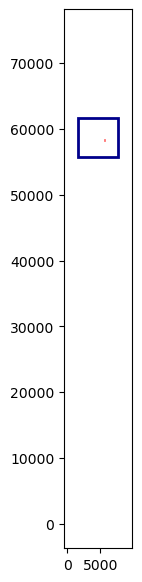

In [13]:
plot_sample(sample, True)
print(sample.policy)

In [14]:
tot_ep = (df_meta.policy == 'easypos').sum()
tot_sn = (df_meta.policy == 'smartneg').sum()
tot_en = (df_meta.policy == 'easyneg').sum()
tot_hn = (df_meta.policy == 'hardneg').sum()
tot_neg = (df_meta.interacting == False).sum()
assert tot_ep == (df_meta.interacting == True).sum()
assert tot_neg == tot_en+tot_sn+tot_hn
print(f'actual smartneg are the {np.round( tot_sn/tot_neg *100, 2)}% of negative pairs')
print(f'actual easyneg are the {np.round( tot_en/tot_neg *100, 2)}% of negative pairs')
print(f'actual hardneg are the {np.round( tot_hn/tot_neg *100, 2)}% of negative pairs')
print(f'actual unbalanced factor is {np.round( tot_ep/(tot_ep+tot_neg) *100, 2)}%')

actual smartneg are the 88.37% of negative pairs
actual easyneg are the 8.9% of negative pairs
actual hardneg are the 2.73% of negative pairs
actual unbalanced factor is 30.9%


### Controllo se alcuni geni hanno un arricchimento solo nei positivi o solo nei negativi.

In [15]:
original_shape = df_meta.shape[0]

unbalanced_ratio = df_meta.interacting.value_counts()[True]/df_meta.interacting.value_counts()[False]
print(f'unbalanced_ratio:{unbalanced_ratio:.2f}')

gene_count = create_gene_count(df_meta, unbalanced_ratio)
weighted_average = np.round(gene_count['abs_diff_weighted'].sum()/gene_count['tot'].sum(),2)
print(f'{weighted_average=}')
df_meta = df_meta.merge(gene_count[['gene', 'diff']], left_on = 'gene1', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff1'}, axis =1)
df_meta = df_meta.merge(gene_count[['gene', 'diff']], left_on = 'gene2', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff2'}, axis =1)
df_meta['diff'] = df_meta['diff1'] + df_meta['diff2']

unbalanced_ratio:0.45
weighted_average=9.38


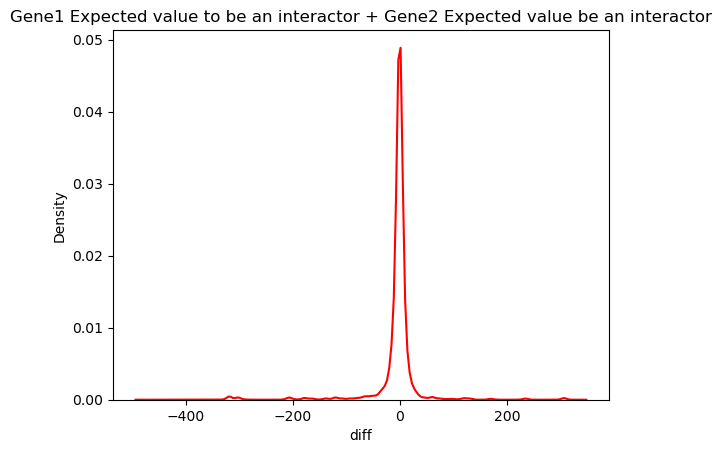

In [16]:
sns.kdeplot(df_meta['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor')
plt.show()

In [17]:
tolerance = 40
print(f'before:{df_meta.shape[0]}')
problematics = df_meta[(df_meta['diff']>tolerance)|(df_meta['diff']<-tolerance)]

df_meta['problematic'] = False
df_meta.loc[ df_meta.id_sample.isin(set(problematics.id_sample)), 'problematic'] = True
subsetted = df_meta[(df_meta['diff']<tolerance)&(df_meta['diff']>-tolerance)]
print(f'after:{subsetted.shape[0]}')
perc = np.round(100 - subsetted.shape[0]/original_shape*100, 2)
print(f'In total, I would loose the {perc}% of the pairs by keeping only the not problematic pairs')

df_meta_clean = subsetted.reset_index(drop = True).drop(['diff', 'diff1', 'diff2'], axis =1)
unbalanced_ratio = df_meta_clean.interacting.value_counts()[True]/df_meta_clean.interacting.value_counts()[False]
print(f'If I cleen the data I would have an unbalanced_ratio:{unbalanced_ratio:.2f}')
gene_count_new = create_gene_count(df_meta_clean, unbalanced_ratio)
weighted_average = np.round(gene_count_new['abs_diff_weighted'].sum()/gene_count_new['tot'].sum(),2)
print(f'If I cleen the data I would have {weighted_average=}')

before:235991
after:218269
In total, I would loose the 7.51% of the pairs by keeping only the not problematic pairs
If I cleen the data I would have an unbalanced_ratio:0.44
If I cleen the data I would have weighted_average=3.65


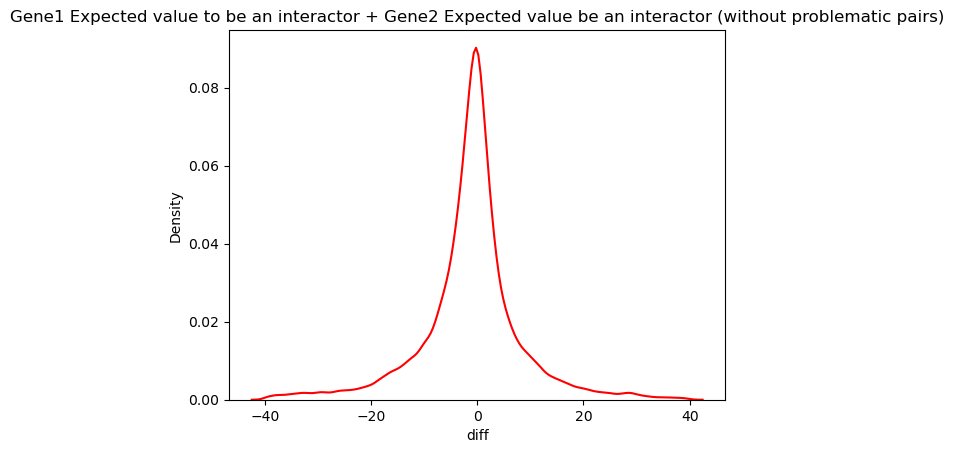

In [18]:
sns.kdeplot(df_meta[df_meta['problematic'] == False]['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor (without problematic pairs)')
plt.show()

In [27]:
assert (df_meta.id_gene1_sample.str.extract('(.*)_(.*)_(.*)')[0] == df_meta.gene1).all()
assert (df_meta.id_gene2_sample.str.extract('(.*)_(.*)_(.*)')[0] == df_meta.gene2).all()

In [28]:
df_meta.to_csv(os.path.join(metadata_dir, f'{set_data}.csv'), index = False)

# Data Loader val

In [11]:
set_data = 'val' 
assert set_data in ['training', 'val', 'test']
subset_file = os.path.join(rna_rna_files_dir, f"gene_pairs_{set_data}.txt")

id_couple = 0
meta = {}

In [12]:
start_time = time.time()

small = get_dataset(ep_per_sample=ep_per_sample_small, sn_per_sample=sn_per_sample_small, 
                    en_persample=en_per_sample_small, hn_per_sample=hn_per_sample_small, 
                    df_genes=df_genes, df=df_small, subset_file=subset_file, 
                    pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                    neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(small), total = len(small)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
medium = get_dataset(ep_per_sample=ep_per_sample_medium, sn_per_sample=sn_per_sample_medium,
                     en_persample=en_per_sample_medium, hn_per_sample=hn_per_sample_medium, 
                     df_genes=df_genes, df=df_medium, subset_file=subset_file,
                     pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                     neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(medium), total = len(medium)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
big = get_dataset(ep_per_sample=ep_per_sample_big, sn_per_sample=sn_per_sample_big, 
                  en_persample=en_per_sample_big, hn_per_sample=hn_per_sample_big, 
                  df_genes=df_genes, df=df_big, subset_file=subset_file, 
                  pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                  neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(big), total = len(big)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
df_meta = pd.DataFrame.from_dict(meta, 'index')
df_meta['lencdna1'] = df_meta.apply(lambda x: len(x.cdna1), axis = 1)
df_meta['lencdna2'] = df_meta.apply(lambda x: len(x.cdna2), axis = 1)
assert (df_meta['lencdna1'] == df_meta['length_1']).all()
assert (df_meta['lencdna2'] == df_meta['length_2']).all()
assert ((df_meta.window_x2 - df_meta.window_x1)==(df_meta.lencdna1)).all()
assert ((df_meta.window_y2 - df_meta.window_y1)==(df_meta.lencdna2)).all()
df_meta = df_meta.drop(['lencdna1', 'lencdna2'], axis = 1)

m = df_meta[df_meta.policy.isin({'smartneg', 'easypos'})]
assert (m.x1 >= 0).all()
assert (m.y1 >= 0).all()
assert (m.x2 <= m.length_1).all()
assert (m.y2 <= m.length_2).all()

assert df_meta[df_meta.length_1==df_meta.original_length1][['gene1', 'id_gene1_sample']].groupby('gene1').nunique().max().iloc[0] == 1
assert df_meta[df_meta.length_2==df_meta.original_length2][['gene2', 'id_gene2_sample']].groupby('gene2').nunique().max().iloc[0] == 1

print(f"Total time to create datasets: {(time.time()-start_time)/60} minutes")

  0%|          | 0/25078 [00:00<?, ?it/s]

  0%|          | 0/18730 [00:00<?, ?it/s]

  0%|          | 0/3829 [00:00<?, ?it/s]

Total time to create datasets: 1.1584193110466003 minutes


I have to undersample df_meta because I want a balanced validation set. I will exclude rows where both genes are in the training set.

In [13]:
df_not_in_train = df_meta[~( (df_meta.gene1.isin(genes_train))|(df_meta.gene2.isin(genes_train)) )]
n_to_exclude = df_meta.interacting.value_counts()[False] - df_meta.interacting.value_counts()[True]
df_to_sample = df_meta[(df_meta.gene1.isin(genes_train))&(df_meta.gene2.isin(genes_train))&(df_meta.interacting == False)]
ids_to_eclude = set(df_to_sample.sample(frac = 1).head(n_to_exclude).id_sample)
assert set(ids_to_eclude).intersection(set(df_not_in_train.id_sample)) == set()
df_meta = df_meta[~df_meta.id_sample.isin(ids_to_eclude)]
assert np.isclose(1, df_meta.interacting.value_counts()[True]/df_meta.interacting.value_counts()[False])
df_meta = df_meta.reset_index(drop = True)

In [18]:
df_meta.to_csv(os.path.join(metadata_dir, f'{set_data}.csv'), index = False)

# Data Loader test 

In [19]:
set_data = 'test' 
assert set_data in ['training', 'val', 'test']
subset_file = os.path.join(rna_rna_files_dir, f"gene_pairs_{set_data}.txt")

id_couple = 0
meta = {}

In [20]:
start_time = time.time()

small = get_dataset(ep_per_sample=ep_per_sample_small, sn_per_sample=sn_per_sample_small, 
                    en_persample=en_per_sample_small, hn_per_sample=hn_per_sample_small, 
                    df_genes=df_genes, df=df_small, subset_file=subset_file, 
                    pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                    neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(small), total = len(small)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
medium = get_dataset(ep_per_sample=ep_per_sample_medium, sn_per_sample=sn_per_sample_medium,
                     en_persample=en_per_sample_medium, hn_per_sample=hn_per_sample_medium, 
                     df_genes=df_genes, df=df_medium, subset_file=subset_file,
                     pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                     neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(medium), total = len(medium)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
big = get_dataset(ep_per_sample=ep_per_sample_big, sn_per_sample=sn_per_sample_big, 
                  en_persample=en_per_sample_big, hn_per_sample=hn_per_sample_big, 
                  df_genes=df_genes, df=df_big, subset_file=subset_file, 
                  pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                  neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(big), total = len(big)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
df_meta = pd.DataFrame.from_dict(meta, 'index')
df_meta['lencdna1'] = df_meta.apply(lambda x: len(x.cdna1), axis = 1)
df_meta['lencdna2'] = df_meta.apply(lambda x: len(x.cdna2), axis = 1)
assert (df_meta['lencdna1'] == df_meta['length_1']).all()
assert (df_meta['lencdna2'] == df_meta['length_2']).all()
assert ((df_meta.window_x2 - df_meta.window_x1)==(df_meta.lencdna1)).all()
assert ((df_meta.window_y2 - df_meta.window_y1)==(df_meta.lencdna2)).all()
df_meta = df_meta.drop(['lencdna1', 'lencdna2'], axis = 1)

m = df_meta[df_meta.policy.isin({'smartneg', 'easypos'})]
assert (m.x1 >= 0).all()
assert (m.y1 >= 0).all()
assert (m.x2 <= m.length_1).all()
assert (m.y2 <= m.length_2).all()

assert df_meta[df_meta.length_1==df_meta.original_length1][['gene1', 'id_gene1_sample']].groupby('gene1').nunique().max().iloc[0] == 1
assert df_meta[df_meta.length_2==df_meta.original_length2][['gene2', 'id_gene2_sample']].groupby('gene2').nunique().max().iloc[0] == 1

print(f"Total time to create datasets: {(time.time()-start_time)/60} minutes")

  0%|          | 0/23911 [00:00<?, ?it/s]

  0%|          | 0/21565 [00:00<?, ?it/s]

  0%|          | 0/5423 [00:00<?, ?it/s]

Total time to create datasets: 2.9426762461662292 minutes


In [25]:
#undersample df_meta
df_not_in_train = df_meta[~( (df_meta.gene1.isin(genes_train))|(df_meta.gene2.isin(genes_train)) )]
n_to_exclude = df_meta.interacting.value_counts()[False] - df_meta.interacting.value_counts()[True]
df_to_sample = df_meta[(df_meta.gene1.isin(genes_train))&(df_meta.gene2.isin(genes_train))&(df_meta.interacting == False)]
ids_to_eclude = set(df_to_sample.sample(frac = 1).head(n_to_exclude).id_sample)
assert set(ids_to_eclude).intersection(set(df_not_in_train.id_sample)) == set()
df_meta = df_meta[~df_meta.id_sample.isin(ids_to_eclude)]
assert np.isclose(1, df_meta.interacting.value_counts()[True]/df_meta.interacting.value_counts()[False])
df_meta = df_meta.reset_index(drop = True)

In [27]:
df_meta.to_csv(os.path.join(metadata_dir, f'{set_data}.csv'), index = False)

# Create the embedding query

In [30]:
#import data 
train = pd.read_csv(os.path.join(metadata_dir, f'training.csv'))
val = pd.read_csv(os.path.join(metadata_dir, f'val.csv'))
test = pd.read_csv(os.path.join(metadata_dir, f'test.csv'))

In [31]:
def create_query_df(df):
    df1 = df[['id_gene1_sample', 'cdna1']].drop_duplicates().rename({'id_gene1_sample':'id_query', 'cdna1':'cdna'}, axis = 1)
    df2 = df[['id_gene2_sample', 'cdna2']].drop_duplicates().rename({'id_gene2_sample':'id_query', 'cdna2':'cdna'}, axis = 1)
    df = pd.concat([df1, df2], axis = 0).drop_duplicates().reset_index(drop = True)
    return df

In [32]:
train_query = create_query_df(train)
val_query = create_query_df(val)
test_query = create_query_df(test)
df_query = pd.concat([train_query, val_query, test_query], axis = 0).drop_duplicates().reset_index(drop = True)
del train_query
del val_query
del test_query

In [33]:
query_train = set(train['id_gene1_sample']).union(set(train['id_gene2_sample']))
query_val = set(val['id_gene1_sample']).union(set(val['id_gene2_sample']))
query_test = set(test['id_gene1_sample']).union(set(test['id_gene2_sample']))
query = set(query_train).union(query_val).union(query_test)

#the 2 assert below also means that there are unique cdna per id_query
assert len(df_query.id_query) == len(query)
assert set(df_query.id_query) == query

In [ ]:
df_query.to_csv(os.path.join(metadata_dir, 'embedding_query.csv'), index = False)

In [49]:
def estimate_time_and_space(n_samples):
    #TIME
    minutes = 5.66*n_samples/(300)
    hours = minutes/60
    days = hours/24
    print('estimated # days:', np.round(days, 2))

    mb = 10.2*n_samples
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (pessimistic):', np.round(tb, 2))
    mb = 1995*n_samples/(300)
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (realistic):', np.round(tb, 2))
estimate_time_and_space(144987)

estimated # days: 1.9
estimated terabytes (pessimistic): 1.48
estimated terabytes (realistic): 0.96


In [35]:
def get_directory_size(directory):
    total_size = 0

    # Walk through all the files and subdirectories in the directory
    for path, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(path, file)
            total_size += os.stat(file_path).st_size

    # Convert the size to a human-readable format
    size_in_bytes = total_size
    size_in_kilobytes = total_size / 1024
    size_in_megabytes = size_in_kilobytes / 1024
    size_in_gigabytes = size_in_megabytes / 1024

    return {
        "bytes": size_in_bytes,
        "kilobytes": size_in_kilobytes,
        "megabytes": size_in_megabytes,
        "gigabytes": size_in_gigabytes
    }

# Usage example
directory_path = os.path.join(embedding_dir)
directory_size = get_directory_size(directory_path)

# Create df_genes_nt and df_nt

In [11]:
#import data 
train = pd.read_csv(os.path.join(metadata_dir, f'training.csv'))
val = pd.read_csv(os.path.join(metadata_dir, f'val.csv'))
test = pd.read_csv(os.path.join(metadata_dir, f'test.csv'))

In [12]:
def swap_if_needed(df):
    df['actual_couples'] = df.gene1 + '_' + df.gene2
    df['need_to_swap'] = df.couples!=df.actual_couples
    where = df.need_to_swap
    df.loc[where, ['gene1', 'gene2']] = (df.loc[where, ['gene2', 'gene1']].values)
    df.loc[where, ['length_1', 'length_2']] = (df.loc[where, ['length_2', 'length_1']].values)
    df.loc[where, ['protein_coding_1', 'protein_coding_2']] = (df.loc[where, ['protein_coding_2', 'protein_coding_1']].values)
    df.loc[where, ['x1', 'y1']] = (df.loc[where, ['y1', 'x1']].values)
    df.loc[where, ['x2', 'y2']] = (df.loc[where, ['y2', 'x2']].values)
    df.loc[where, ['cdna1', 'cdna2']] = (df.loc[where, ['cdna2', 'cdna1']].values)
    df.loc[where, ['original_x1', 'original_y1']] = (df.loc[where, ['original_y1', 'original_x1']].values)
    df.loc[where, ['original_x2', 'original_y2']] = (df.loc[where, ['original_y2', 'original_x2']].values)
    df.loc[where, ['window_x1', 'window_y1']] = (df.loc[where, ['window_y1', 'window_x1']].values)
    df.loc[where, ['window_x2', 'window_y2']] = (df.loc[where, ['window_y2', 'window_x2']].values)
    df.loc[where, ['original_length1', 'original_length2']] = (df.loc[where, ['original_length2', 'original_length1']].values)
    df.loc[where, ['id_gene1_sample', 'id_gene2_sample']] = (df.loc[where, ['id_gene2_sample', 'id_gene1_sample']].values)
    if ('diff1' in df.columns)&('diff2' in df.columns):
        df.loc[where, ['diff1', 'diff2']] = (df.loc[where, ['diff2', 'diff1']].values)
    df['actual_couples'] = df.gene1 + '_' + df.gene2
    assert (df.couples==df.actual_couples).all()
    return df.drop(['need_to_swap', 'actual_couples'], axis = 1)

In [13]:
train = swap_if_needed(train)
val = swap_if_needed(val)
test = swap_if_needed(test)

In [14]:
train['couples_id'] = train['couples']
train['couples'] = train['couples_id'] + '_' + train['policy']

val['couples_id'] = val['couples']
val['couples'] = val['couples_id'] + '_' + val['policy']

test['couples_id'] = test['couples']
test['couples'] = test['couples_id'] + '_' + test['policy']

# export subsets

with open(os.path.join(rna_rna_files_dir, f"gene_pairs_training_nt.txt"), "wb") as fp:   #Pickling
    pickle.dump(list(set(train.couples)), fp)
    
with open(os.path.join(rna_rna_files_dir, f"gene_pairs_test_nt.txt"), "wb") as fp:   #Pickling
    pickle.dump(list(set(test.couples)), fp)
    
with open(os.path.join(rna_rna_files_dir, f"gene_pairs_val_nt.txt"), "wb") as fp:   #Pickling
    pickle.dump(list(set(val.couples)), fp)

In [15]:
#create fake_interaction_region
interaction_size= 16

def create_fake_interaction_region(df, interaction_size=16):
    subset = df[df.policy.isin(['hardneg', 'easyneg'])]
    
    length1_values = subset['length_1'].values - interaction_size
    length2_values = subset['length_2'].values - interaction_size

    # Generate random indices within the length1 range
    x1_indices = np.random.randint(0, length1_values, size=len(subset))
    x2_indices = x1_indices + interaction_size  # Ensure a distance of interaction_size between x1 and x2

    # Generate random indices within the length2 range
    y1_indices = np.random.randint(0, length2_values, size=len(subset))
    y2_indices = y1_indices + interaction_size  # Ensure a distance of interaction_size between y1 and y2
    
    df.loc[df.policy.isin(['hardneg', 'easyneg']), 'x1'] = x1_indices
    df.loc[df.policy.isin(['hardneg', 'easyneg']), 'x2'] = x2_indices
    df.loc[df.policy.isin(['hardneg', 'easyneg']), 'y1'] = y1_indices
    df.loc[df.policy.isin(['hardneg', 'easyneg']), 'y2'] = y2_indices
    return df


train = create_fake_interaction_region(train)
test = create_fake_interaction_region(test)
val = create_fake_interaction_region(val)

assert (train.x2<=train.length_1).all()
assert (test.x2<=test.length_1).all()
assert (val.x2<=val.length_1).all()

assert (train.x1>=0).all()
assert (test.x1>=0).all()
assert (val.x1>=0).all()

subset = train[train.policy.isin(['hardneg', 'easyneg'])]
assert ((subset.x2-subset.x1) == interaction_size).all()
subset = test[test.policy.isin(['hardneg', 'easyneg'])]
assert ((subset.x2-subset.x1) == interaction_size).all()
subset = val[val.policy.isin(['hardneg', 'easyneg'])]
assert ((subset.x2-subset.x1) == interaction_size).all()

In [16]:
df_full = pd.concat([train, val, test], axis = 0)
df_full = df_full.rename({'gene1':'gene1_id', 'gene2':'gene2_id'}, axis = 1)
df_full = df_full.rename({'id_gene1_sample':'gene1', 'id_gene2_sample':'gene2'}, axis = 1)

In [17]:
df_nt = df_full.copy()
df_nt['w'] = df_nt['x2'] - df_nt['x1']
df_nt['h'] = df_nt['y2'] - df_nt['y1']
df_nt = df_nt.reset_index(drop = True)
column_order = ['couples','gene1','gene2','interacting',
                'length_1','length_2','protein_coding_1','protein_coding_2',
                'x1','y1','w','h', 'id_sample', 'policy',
                'original_x1','original_x2','original_y1','original_y2',
                'id_gene1_sample','id_gene2_sample', 'couples_id',
                'diff1','diff2','diff','problematic'
               ]
df_nt = df_nt.filter(column_order, axis = 1)
#crea coordinate per easyneg e hardneg
df_nt.to_csv(os.path.join(metadata_dir, f'df_nt.csv'), index = False)

In [18]:
column_order = [
    'gene1','gene2','id_gene1_sample','id_gene2_sample',
    'original_length1','original_length2', 'cdna1', 'cdna2',
    'window_x1','window_x2','window_y1','window_y2', 
    'gene1_id', 'gene2_id', 'protein_coding_1',  'protein_coding_2'
]

df_g = df_full.filter(column_order, axis = 1)

df_g1 = df_g.filter(
    [
    'gene1', 
    'id_gene1_sample', 
    'cdna1', 
    'window_x1',
    'window_x2', 
    'gene1_id',
    'protein_coding_1', 
    'length_1',
    'original_length1', 
    ]
).rename(
    {
    'gene1':'gene_id',
    'cdna1':'cdna', 
    'length_1':'length',
    'window_x1':'window_c1',
    'window_x2':'window_c2',
    'gene1_id':'original_gene_id', 
    'protein_coding_1':'protein_coding', 
    'original_length1':'original_length'
    }, 
    axis = 1)
df_g2 = df_g.filter(
    [
    'gene2', 
    'id_gene2_sample', 
    'cdna2', 
    'window_y1',
    'window_y2', 
    'gene2_id',
    'protein_coding_2', 
    'length_2',
    'original_length2', 
    ]
).rename(
    {
    'gene2':'gene_id',
    'cdna2':'cdna', 
    'length_2':'length',
    'window_y1':'window_c1',
    'window_y2':'window_c2',
    'gene2_id':'original_gene_id', 
    'protein_coding_2':'protein_coding', 
    'original_length2':'original_length'
    }, 
    axis = 1)

df_genes_nt = pd.concat([df_g1, df_g2], axis = 0).drop_duplicates().reset_index(drop = True)

df_genes_nt['UTR5'] = 0
df_genes_nt['CDS'] = 0
df_genes_nt['UTR3'] = 0

In [19]:
assert set(df_genes.gene_id) == set(df_genes_nt.original_gene_id)
assert set(df.gene1).union(df.gene2) == set(train.gene1).union(train.gene2).union(val.gene1).union(val.gene2).union(test.gene1).union(test.gene2)
assert set(df.gene1).union(df.gene2) == set(df_full.gene1_id).union(df_full.gene2_id)

In [20]:
df_genes_nt.to_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'), index = False)

# Check the data saved

In [21]:
train = pd.read_csv(os.path.join(metadata_dir, f'training.csv'))
val = pd.read_csv(os.path.join(metadata_dir, f'val.csv'))
test = pd.read_csv(os.path.join(metadata_dir, f'test.csv'))

assert max(train.length_1.max(), train.length_2.max()) == MAX_RNA_SIZE

with open(os.path.join(rna_rna_files_dir, f"gene_pairs_training.txt"), "rb") as fp:  # Unpickling
    subset_train = pickle.load(fp)
    subset = pd.Series(subset_train).str.split('_', expand = True)
    genes_train = set(subset[0]).union(set(subset[1]))

with open(os.path.join(rna_rna_files_dir, f"gene_pairs_test.txt"), "rb") as fp:  # Unpickling
    subset_test = pickle.load(fp)
    subset = pd.Series(subset_test).str.split('_', expand = True)
    genes_test = set(subset[0]).union(set(subset[1]))
    
with open(os.path.join(rna_rna_files_dir, f"gene_pairs_val.txt"), "rb") as fp:  # Unpickling
    subset_val = pickle.load(fp)
    subset = pd.Series(subset_val).str.split('_', expand = True)
    genes_val = set(subset[0]).union(set(subset[1]))
    
assert set(train[train.gene1.isin(genes_train)|train.gene2.isin(genes_train)].id_sample) == set(train.id_sample)
assert set(train[train.couples.isin(subset_train)].id_sample) == set(train.id_sample)

assert set(test[test.gene1.isin(genes_test)|test.gene2.isin(genes_test)].id_sample) == set(test.id_sample)
assert set(test[test.couples.isin(subset_test)].id_sample) == set(test.id_sample)

assert set(val[val.gene1.isin(genes_val)|val.gene2.isin(genes_val)].id_sample) == set(val.id_sample)
assert set(val[val.couples.isin(subset_val)].id_sample) == set(val.id_sample)

In [8]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))

df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))

subset_train_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_training_nt.txt")
subset_test_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_test_nt.txt")
subset_val_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_val_nt.txt")

assert (df_nt.x1 >= 0).all()
assert (df_nt.y1 >= 0).all()
assert ((df_nt.x1 + df_nt.w) <= df_nt.length_1).all()
assert ((df_nt.y1 + df_nt.h) <= df_nt.length_2).all()
assert df_genes_nt.apply(lambda x: len(x.cdna) == (x.window_c2-x.window_c1), axis = 1).all()

/tmp/ipykernel_219155/2620639963.py:1: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))


In [9]:
pos_width_multipliers = {1_000_000: 1.}
pos_height_multipliers = pos_width_multipliers
neg_width_windows = {(MAX_RNA_SIZE-1, MAX_RNA_SIZE): float(1),}
neg_height_windows = neg_width_windows

policies = [
    EasyPosAugment(
    per_sample=1,
    interaction_selection=InteractionSelectionPolicy.LARGEST,
    width_multipliers=pos_width_multipliers,
    height_multipliers=pos_height_multipliers,
    ),  
    SmartNegAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
    ),
]

dataset = RNADataset(
        gene2info=df_genes_nt,
        interactions=df_nt,
        subset_file=subset_test_nt,
        augment_policies=policies,
)

In [10]:
del df_nt
del df_genes_nt

In [ ]:
all_couples = set(df.couples)

for s in tqdm(dataset):
    interacting, policy = s.interacting, s.policy
    original_length1, original_length2 = s.gene1_info['protein_coding'], s.gene2_info['protein_coding']

    couple_id = s.gene1_info['original_gene_id'] + '_' + s.gene2_info['original_gene_id']
    couple_id_swapped = s.gene2_info['original_gene_id'] + '_' + s.gene1_info['original_gene_id']
    
    if couple_id in all_couples:
        gene1_id, gene2_id = s.gene1, s.gene2
        gene1_info, gene2_info = s.gene1_info, s.gene2_info
        original_gene_id1, original_gene_id2 = gene1_info['original_gene_id'], gene2_info['original_gene_id']
        cdna_slice1, cdna_slice2 = gene1_info['cdna'], gene2_info['cdna']
        window_x1, window_x2 = gene1_info['window_c1'], gene1_info['window_c2']
        window_y1, window_y2 = gene2_info['window_c1'], gene2_info['window_c2']
        protein_coding1, protein_coding2 = gene1_info['protein_coding'], gene2_info['protein_coding']
        real_couple_id = couple_id
    elif couple_id_swapped in all_couples:
        gene2_id, gene1_id = s.gene1, s.gene2
        gene2_info, gene1_info = s.gene1_info, s.gene2_info
        original_gene_id2, original_gene_id1 = gene1_info['original_gene_id'], gene2_info['original_gene_id']
        cdna_slice2, cdna_slice1 = gene1_info['cdna'], gene2_info['cdna']
        window_y1, window_y2 = gene1_info['window_c1'], gene1_info['window_c2']
        window_x1, window_x2 = gene2_info['window_c1'], gene2_info['window_c2']
        protein_coding2, protein_coding1 = gene1_info['protein_coding'], gene2_info['protein_coding']
        real_couple_id = couple_id_swapped
    else:
        raise NotImplementedError
        
    assert gene1_id == gene1_info['gene_id']
    assert gene2_id == gene2_info['gene_id']
    assert window_x2-window_x1 == len(cdna_slice1)
    assert window_y2-window_y1 == len(cdna_slice2)
    
    real1 = df_genes[df_genes.gene_id == original_gene_id1].iloc[0]
    real2 = df_genes[df_genes.gene_id == original_gene_id2].iloc[0]

    assert real1['cdna'][window_x1:window_x2] == cdna_slice1
    assert real2['cdna'][window_y1:window_y2] == cdna_slice2
    assert real1.protein_coding == protein_coding1
    assert real2.protein_coding == protein_coding2
    
    real_df = df[df.couples == real_couple_id].iloc[0]
    if policy == 'easypos':
        assert real_df.interacting == interacting == True
    if policy == 'hardneg':
        assert real_df.interacting == True
        assert interacting == False
    elif policy in ['smartneg', 'easyneg']:
        assert real_df.interacting == interacting == False
    assert real_df.protein_coding_1 == protein_coding1
    assert real_df.protein_coding_2 == protein_coding2
    
    #TODO: 
    # SISTEMA QUESTO ERRORE SUI PROTEIN CODING
    # FAI GLI ASSERT SULLE REGIONI DI INTERAZIONE